# How to Python Web Scrape the Nasdaq Stock Ex-Dividend Calendar

https://medium.com/c%C3%B3digo-ecuador/how-to-python-web-scrape-the-nasdaq-stock-ex-dividend-calendar-648b6063c659

Web scrape a list of stocks with upcoming ex-dividend dates from the Nasdaq API using the Python pandas, requests, datetime, and calendar modules.

## Install & import required Python packages

You will need the pandas, requests, datetime, and calendar modules to web scrape a list of stocks with upcoming ex-dividend dates from the Nasdaq API using the Python coding language. 


In [4]:
import pandas, requests, calendar
import datetime as dt
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import yfinance as yf
from tqdm import tqdm
import numpy as np
import pandas as pd
pandas.set_option('display.expand_frame_repr', False)


In [22]:
class dividend_calendar:
    #class attributes 
    calendars = [] 
    url = 'https://api.nasdaq.com/api/calendar/dividends'
    hdrs =  {'Accept': 'application/json, text/plain, */*',
                 'DNT': "1",
                 'Origin': 'https://www.nasdaq.com/',
                 'Sec-Fetch-Mode': 'cors',
                 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0)'}

    def __init__(self, year=0, month=0, day=0):
        '''
        Parameters
        ----------
        year: year int
        month: month int
        day: day int

        Returns
        -------
        DateTime object.

        '''
        if not year and not month and not day:
            self.date = dt.datetime.now()
        else:
            self.date = dt.date(year, month, day)

        #instance attributes
        self.year = int(year)
        self.month = int(month)

    def date_str(self, day):
        date_obj = dt.date(self.year, self.month, day)
        date_str = date_obj.strftime(format='%Y-%m-%d')     
        return date_str
    
    def scraper(self, date):
        ''' 
        Scrapes JSON object from page using requests module.
          
        Parameters
        - - - - - 
        url : URL string
        hdrs : Header information
        date_str: string in yyyy-mm-dd format
             
        Returns
        - - - -
        dictionary : Returns a JSON dictionary at a given URL.
         
        '''
        params = {'date': date.strftime(format='%Y-%m-%d')}
        page=requests.get(self.url,headers=self.hdrs,params=params)
        dictionary = page.json()
        return dictionary
    
    def dict_to_df(self, dicti):
        ''' 
        Converts the JSON dictionary into a pandas dataframe
        Appends the dataframe to calendars class attribute         
        
        Parameters
        ----------
        dicti : Output from the scraper method as input.
        
        Returns
        -------
        calendar : Dataframe of stocks with that exdividend date
        
        Appends the dataframe to calendars class attribute
        
        If the date is formatted correctly, it will append a 
        dataframe to the calendars list (class attribute).  
        Otherwise, it will return an empty dataframe.         
        '''
         
        rows = dicti.get('data').get('calendar').get('rows')
        calendar = pandas.DataFrame(rows)
        self.calendars.append(calendar)
        return calendar
   
            
    def calendar(self, weeks = 1):
        '''
        Combines the scrape and dict_to_df methods
        
        Parameters
        ----------
        day : day of the month as string or number.
        
        Returns
        -------
        dictionary : Returns a JSON dictionary with keys 
        dictionary.keys() => data, message, status
        
        Next Levels: 
        dictionary['data'].keys() => calendar, timeframe
        dictionary['data']['calendar'].keys() => headers, rows
        dictionary['data']['calendar']['headers'] => column names
        dictionary['data']['calendar']['rows'] => dictionary list
    
        '''
        
        delta_days = ( 7*weeks + 4 - self.date.weekday() % 7)

        for i in range(1, delta_days+1):
            date = self.date + dt.timedelta(i)
            dictionary = self.scraper(date)
            self.dict_to_df(dictionary)          
        return dictionary

if __name__ == '__main__':

    #create calendar object    
    dc = dividend_calendar()

    # get all dividend calender til next Friday     
    dc.calendar()

    #concatenate all the calendars in the class attribute
    concat_df = pandas.concat(dc.calendars)
    
    #Drop any rows with missing data
    drop_df = concat_df.dropna(how='any')
    
    #set the dataframe's row index to the company name
    final_df = drop_df.set_index('companyName')

    print(final_df.info())
    print(final_df.tail())

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, APA Corporation Common Stock to Victory Bancorp Inc
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   symbol                     168 non-null    object 
 1   dividend_Ex_Date           168 non-null    object 
 2   payment_Date               168 non-null    object 
 3   record_Date                168 non-null    object 
 4   dividend_Rate              168 non-null    float64
 5   indicated_Annual_Dividend  168 non-null    float64
 6   announcement_Date          168 non-null    object 
dtypes: float64(2), object(5)
memory usage: 10.5+ KB
None
                                                   symbol dividend_Ex_Date payment_Date record_Date  dividend_Rate  indicated_Annual_Dividend announcement_Date
companyName                                                                                                                             

In [23]:
today_price = []
today_volume = []

for symbol in tqdm(list(final_df['symbol'])):
    symbol = symbol.replace('.', '-')
    company = yf.Ticker(symbol)
    df2 = company.history(period="7d")
    df2.dropna(inplace=True)
    p, v = 999999999.0, 0
    if not df2.empty:
        p = df2.iloc[-1, df2.columns.get_loc('Close')]
        v = df2.iloc[-1, df2.columns.get_loc('Volume')]
    today_price.append(p)
    today_volume.append(v)

today_time = dt.datetime.now()
final_df[today_time] = today_price
final_df['Volume'] = today_volume
div_perc= final_df['dividend_Rate'] / final_df[today_time] * 100.0
final_df.insert(2, 'Dividend Percent', div_perc.round(2))


100%|██████████| 168/168 [00:33<00:00,  5.05it/s]


                                                   symbol dividend_Ex_Date  Dividend Percent payment_Date record_Date  dividend_Rate  indicated_Annual_Dividend announcement_Date  2024-01-18 11:47:08.303858   Volume
companyName                                                                                                                                                                                                           
APA Corporation Common Stock                          APA        1/19/2024              0.82    2/22/2024   1/22/2024       0.250000                    1.00000        12/12/2023                   30.465000  2252879
B. Riley Financial, Inc. Depositary Shares each...  RILYL        1/19/2024              2.28    1/31/2024   1/22/2024       0.460938                    1.84375         1/18/2024                   20.221600     5678
B. Riley Financial, Inc. Depositary Shares, eac...  RILYP        1/19/2024              2.26    1/31/2024   1/22/2024       0.429688        

(0.0, 5.0)

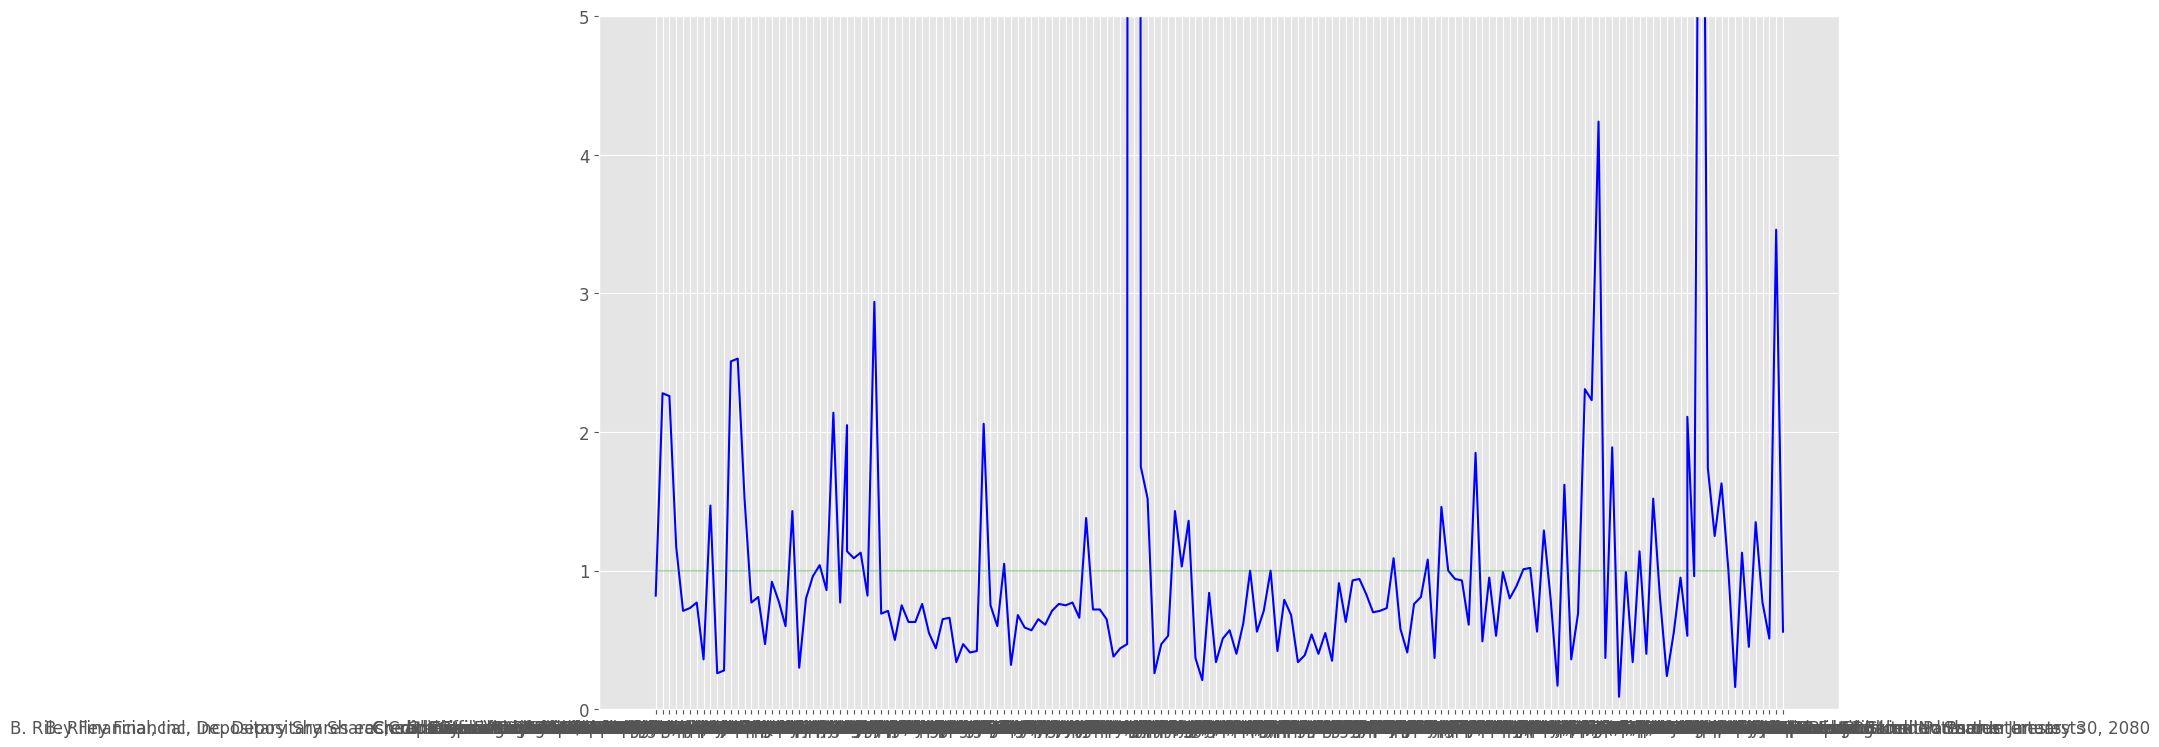

In [24]:
# Output all stocks that dividend > threshold
threshold = 0.5
print(final_df[final_df['Dividend Percent'] >= threshold])

# reorder columns
print(final_df.columns)
final_df = final_df[['symbol', 'dividend_Ex_Date', 'Dividend Percent', 'Volume', 
                     today_time, 'dividend_Rate', 'indicated_Annual_Dividend',
                    'payment_Date', 'record_Date', 'announcement_Date']]

# final_df[final_df['Dividend_Perc'] >= threshold].to_csv('stock_dividend.csv')
final_df[final_df['Dividend Percent'] >= threshold].to_csv(f"stock_dividend_{today_time.strftime(format='%Y-%m-%d')}.csv")

plt.plot(final_df['Dividend Percent'], color='blue')
plt.plot(final_df.index, [1]*len(final_df.index), color='green', alpha=0.25)
plt.ylim([0, 5])

In [5]:
'''
start = dt.datetime(year, month, 1)
end = dt.datetime.now()
start = end - dt.timedelta(days=7)
today_price = []

for symbol in list(final_df['symbol']):
    symbol = symbol.replace('.', '-')
    df2 = web.DataReader(symbol, 'yahoo', start, end)
    df2.reset_index(inplace=True)
    df2.set_index("Date", inplace=True)
    today_price.append(df2.iloc[-1, df2.columns.get_loc('Adj Close')])
    
# print(len(final_df.index), len(today_price))
# print(today_price)
final_df['Today_Price'] = today_price
    
print(final_df.tail())
'''

'\nstart = dt.datetime(year, month, 1)\nend = dt.datetime.now()\nstart = end - dt.timedelta(days=7)\ntoday_price = []\n\nfor symbol in list(final_df[\'symbol\']):\n    symbol = symbol.replace(\'.\', \'-\')\n    df2 = web.DataReader(symbol, \'yahoo\', start, end)\n    df2.reset_index(inplace=True)\n    df2.set_index("Date", inplace=True)\n    today_price.append(df2.iloc[-1, df2.columns.get_loc(\'Adj Close\')])\n    \n# print(len(final_df.index), len(today_price))\n# print(today_price)\nfinal_df[\'Today_Price\'] = today_price\n    \nprint(final_df.tail())\n'

In [7]:
'''
# Original script

import pandas, requests, datetime, calendar
class dividend_calendar:
    #class attributes 
    calendars = [] 
    url = 'https://api.nasdaq.com/api/calendar/dividends'
    hdrs =  {'Accept': 'application/json, text/plain, */*',
                 'DNT': "1",
                 'Origin': 'https://www.nasdaq.com/',
                 'Sec-Fetch-Mode': 'cors',
                 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0)'}
def __init__(self, year, month):
          '''
        Parameters
        ----------
        year : year int
        month : month int
        
        Returns
        -------
        Sets instance attributes for year and month of object.
        
          '''
          #instance attributes
          self.year = int(year)
          self.month = int(month)
     
     def date_str(self, day):
          date_obj = datetime.date(self.year, self.month, day)
          date_str = date_obj.strftime(format='%Y-%m-%d')     
          return date_str
     def scraper(self, date_str):
         ''' 
          Scrapes JSON object from page using requests module.
           
           Parameters
           - - - - - 
           url : URL string
           hdrs : Header information
           date_str: string in yyyy-mm-dd format
               
           Returns
           - - - -
           dictionary : Returns a JSON dictionary at a given URL.
         
         '''
         params = {'date': date_str}
         page=requests.get(self.url,headers=self.hdrs,params=params)
         dictionary = page.json()
         return dictionary
    
     def dict_to_df(self, dicti):
         ''' 
         Converts the JSON dictionary into a pandas dataframe
         Appends the dataframe to calendars class attribute         
         
         Parameters
         ----------
         dicti : Output from the scraper method as input.
         
         Returns
         -------
         calendar : Dataframe of stocks with that exdividend date
         
         Appends the dataframe to calendars class attribute
         
         If the date is formatted correctly, it will append a 
         dataframe to the calendars list (class attribute).  
         Otherwise, it will return an empty dataframe.         
         '''
         
         rows = dicti.get('data').get('calendar').get('rows')
         calendar = pandas.DataFrame(rows)
         self.calendars.append(calendar)
         return calendar
   
            
    def calendar(self, day):
          '''
          Combines the scrape and dict_to_df methods
          
          Parameters
          ----------
          day : day of the month as string or number.
          
          Returns
          -------
          dictionary : Returns a JSON dictionary with keys 
          dictionary.keys() => data, message, status
          
          Next Levels: 
          dictionary['data'].keys() => calendar, timeframe
          dictionary['data']['calendar'].keys() => headers, rows
          dictionary['data']['calendar']['headers'] => column names
          dictionary['data']['calendar']['rows'] => dictionary list
    
          '''
          day = int(day)
          date_str = self.date_str(day)      
          dictionary = self.scraper(date_str)
          self.dict_to_df(dictionary)          
          return dictionary
           
if __name__ == '__main__':
    year = 2020
    month = 2
    
#get number of days in month
    days_in_month = calendar.monthrange(year, month)[1]
#create calendar object    
    february = dividend_calendar(year, month)
#define lambda function to iterate over list of days     
    function = lambda days: february.calendar(days)
    
#define list of ints between 1 and the number of days in the month
    iterator = list(range(1, days_in_month+1))
#Scrape calendar for each day of the month                    
    objects = list(map(function, iterator))
#concatenate all the calendars in the class attribute
    concat_df = pandas.concat(february.calendars)
    
#Drop any rows with missing data
    drop_df = concat_df.dropna(how='any')
    
#set the dataframe's row index to the company name
    final_df = drop_df.set_index('companyName')
'''

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 48)